In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip "/content/drive/MyDrive/UTKFace.zip" -d "/content/UTKFace"

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: /content/UTKFace/utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: /content/UTKFace/utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: /content/UTKFace/utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: /content/UTKFace/utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: /content/UTKFace/utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: /content/UTKFace/utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: /content/UTKFace/utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: /content/UTKFace/utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: /content/UTKFace/utkface_aligned_cropped/crop_part1/34_1_2_2017010417

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, accuracy_score
import random
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

In [ ]:
DATA_DIR = "/content/UTKFace/UTKFace"

#Redimensionnement
IMG_HEIGHT = 64
IMG_WIDTH = 64

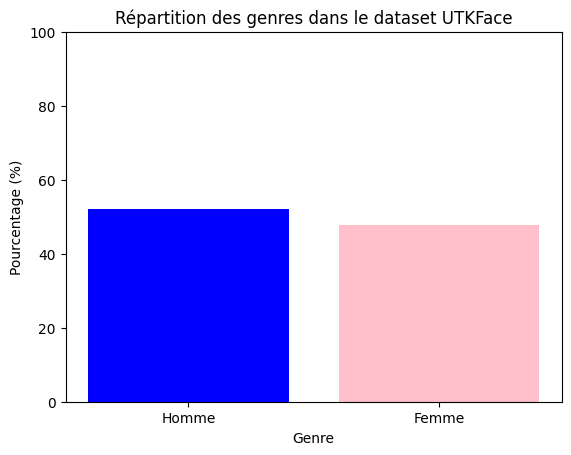

In [ ]:
file_names = os.listdir(DATA_DIR)
sex_labels = []
for file in file_names:
    # Le format est "age_sexe_ethnie_dateNaiss.jpg"
    parts = file.split('_')
    if len(parts) > 1:  # Vérifie que le format est correct
        sex_labels.append(int(parts[1]))  # Le deuxième élément est le sexe (0 = Homme, 1 = Femme)

# Compter les occurrences pour chaque sexe
labels, counts = np.unique(sex_labels, return_counts=True)

# Convertir les comptes en pourcentages
percentages = (counts / counts.sum()) * 100

# Noms des classes
class_names = ["Homme", "Femme"]

# Visualiser en graphique à barres
plt.bar(class_names, percentages, color=['blue', 'pink'])
plt.title("Répartition des genres dans le dataset UTKFace")
plt.ylabel("Pourcentage (%)")
plt.xlabel("Genre")
plt.ylim(0, 100)  # Limiter l'axe des ordonnées de 0 à 100
plt.show()

Y'a presque autant d'homme que de femme.
Cad que le modèle n’aura pas besoin de manip spéciales pour gérer un déséquilibre de classes.

Partie 1

In [ ]:
#TRAITEMENT DE L'IMAGE

def load_data(data_dir=DATA_DIR):
    X = [] #liste d'img après traitement convertit en NumPY
    y = [] #liste contenant les genres

    # Récup tts les img dans UTKFace
    file_names = os.listdir(data_dir)

    for file in file_names:
        # nom de fichier type "age_sexe_ethnie_dateNaiss.jpg"
        # On récupère le deuxième champ pour le genre
        # 0 => Homme, 1 => Femme
        parts = file.split("_")
        gender_str = parts[1]
        try:
            gender = int(gender_str)
        except:
            continue

        # lecture
        img_path = os.path.join(data_dir, file)
        img = cv2.imread(img_path)
        if img is None:
            continue

        # conversion en RGB (cv2 lit en BGR par défaut)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # redimension
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))

        # Normalisation
        img = img.astype("float32") / 255.0

        X.append(img)
        y.append(gender)

    return np.array(X), np.array(y)

# Chargement des données
X, y = load_data(DATA_DIR)

print("Nombre d'images chargées :", len(X))
print("Dimension de X :", X.shape)
print("Dimension de y :", y.shape)

Nombre d'images chargées : 23708
Dimension de X : (23708, 64, 64, 3)
Dimension de y : (23708,)


In [ ]:
#DIVISER LE JEU DE DONN2ES :

# 1. Jeu d'entraînement (X_train, y_train) : utilisé pour entraîner le modèle.
    #Jeu de test (X_test, y_test) : utilisé pour évaluer les performances du modèle sur des données qu'il n'a jamais vues.
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,    # 20% pour le jeu de test
    stratify=y         # Proportions de classes respectées
)

# 2. Séparer l'entraînement en sous-ensemble d'entraînement et de validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,  # 10% de l'entraînement pour la validation
    stratify=y_train
)

print("Taille du jeu d'entraînement :", X_train.shape, len(y_train))
print("Taille du jeu de test :", X_test.shape, len(y_test))

Taille du jeu d'entraînement : (15172, 64, 64, 3) 15172
Taille du jeu de test : (4742, 64, 64, 3) 4742


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 62, 62, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 31, 31, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 15376)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │         246,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 246,497 (962.88 KB)

 Trainable params: 246,497 (962.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 40s 82ms/step - accuracy: 0.7347 - loss: 0.5547 - val_accuracy: 0.8445 - val_loss: 0.3494
Epoch 2/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 35s 74ms/step - accuracy: 0.8652 - loss: 0.3247 - val_accuracy: 0.8463 - val_loss: 0.3692
Epoch 3/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 38s 68ms/step - accuracy: 0.8772 - loss: 0.2956 - val_accuracy: 0.8701 - val_loss: 0.2976
Epoch 4/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 32s 67ms/step - accuracy: 0.8864 - loss: 0.2749 - val_accuracy: 0.8827 - val_loss: 0.2711
Epoch 5/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 41s 68ms/step - accuracy: 0.9013 - loss: 0.2394 - val_accuracy: 0.8832 - val_loss: 0.2725
Epoch 6/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 42s 69ms/step - accuracy: 0.9132 - loss: 0.2175 - val_accuracy: 0.8722 - val_loss: 0.2810
Epoch 7/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 40s 67ms/step - accuracy: 0.9103 - loss: 0.2184 - val_accuracy: 0.8864 - val_loss: 0.2688
Epoch 8/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 31s 66ms/step - accuracy: 0.9217 - loss: 0.1988 - 

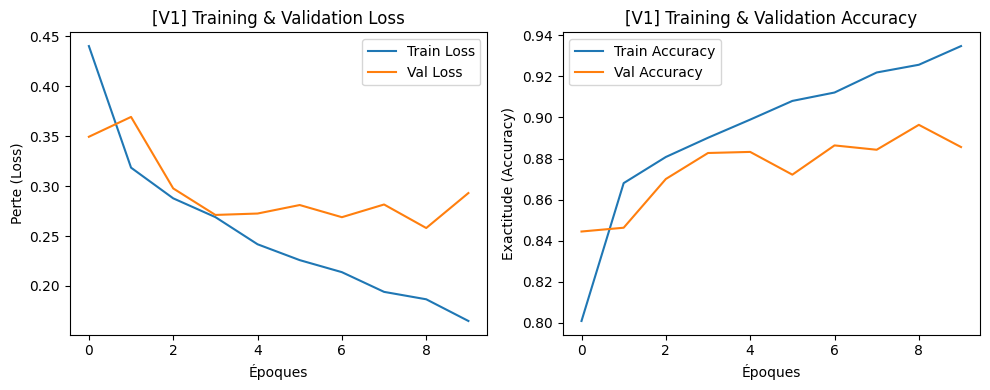

In [ ]:
# PREMIER ESSAI : OBSERVATION

def build_model_v1(input_shape=(64, 64, 3)):
    model = Sequential([
        Input(shape=input_shape),                 # Entrée du réseau (images 64 x 64 en RGB)

        Conv2D(16, (3, 3), activation='relu'),    # Convolution: 16 filtres, kernel 3x3, activation ReLU
        MaxPooling2D((2, 2)),                     # MaxPooling: réduit la dimension spatiale de moitié (64→32)

        Flatten(),                                # Aplatissement pour passer de la partie "convolutive" à la partie "dense"

        Dense(16, activation='relu'),             # Couche fully-connected (dense) avec 16 neurones
        Dense(1, activation='sigmoid')            # Couche de sortie: 1 neurone pour la classification binaire (Homme/Femme)
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),      # Optimiseur Adam, taux d'apprentissage de 0.001
        loss='binary_crossentropy',               # Fonction de perte adaptée à un problème de classification binaire
        metrics=['accuracy']                      # Métrique principale: accuracy
    )
    return model


model_v1 = build_model_v1((64, 64, 3))
model_v1.summary()


history_v1 = model_v1.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,        # Nombre d'époques
    batch_size=32,    # Taille de batch
    verbose=1
)


test_loss_v1, test_acc_v1 = model_v1.evaluate(X_test, y_test, verbose=0)
print(f"[V1] Test accuracy: {test_acc_v1:.4f}")

y_pred_prob_v1 = model_v1.predict(X_test)
y_pred_v1 = (y_pred_prob_v1 > 0.5).astype("int32")
print(classification_report(y_test, y_pred_v1, target_names=["Homme", "Femme"]))


plt.figure(figsize=(10,4))

# Courbe de la fonction de perte (Loss)
plt.subplot(1,2,1)
plt.plot(history_v1.history['loss'], label='Train Loss')
plt.plot(history_v1.history['val_loss'], label='Val Loss')
plt.xlabel('Époques')
plt.ylabel('Perte (Loss)')
plt.legend()
plt.title('[V1] Training & Validation Loss')

# Courbe de l’Accuracy
plt.subplot(1,2,2)
plt.plot(history_v1.history['accuracy'], label='Train Accuracy')
plt.plot(history_v1.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Époques')
plt.ylabel('Exactitude (Accuracy)')
plt.legend()
plt.title('[V1] Training & Validation Accuracy')

plt.tight_layout()
plt.show()

Format d’entrée (64×64×3)

Les images sont redimensionnées à 64×64 pixels et converties en RGB (3 canaux).
La taille 64×64 est relativement petite (pour des questions de vitesse d’entraînement et de mémoire), mais reste suffisante pour une première observatiion.

1) Couche Convolutionnelle : Conv2D(16, (3,3))

Cette couche apprend 16 filtres de taille 3×3 chacun.
L’activation ReLU permet d’introduire de la non-linéarité et accélère l’entraînement.
16 filtres, c’est un nombre très modeste comparé aux modèles de zinzin (qui peuvent monter à des centaines, voire milliers de filtres). Ici, on souhaite volontairement commencer simple.

2) Couche de Pooling : MaxPooling2D((2,2))

Réduit la dimension spatiale (hauteur et largeur) d’un facteur 2.
Permet de résumer localement l’information tout en réduisant le nombre de paramètres et en contrôlant le risque de surapprentissage.

3) Flatten()

Transforme le volume 2D (issu du bloc convolution + pooling) en un vecteur 1D pour passer aux couches denses.

4) Couche Dense : Dense(16, activation='relu')

16 neurones fully-connected, activation ReLU.
Encore une fois, ce nombre est faible : cela limite la capacité du réseau mais évite de trop grosses computations.

5) Couche de sortie : Dense(1, activation='sigmoid')

Puisqu’il s’agit d’une classification binaire (Homme vs Femme), on a un seul neurone en sortie.
La sortie prend une valeur entre 0 et 1, qu’on interprétera comme la probabilité que l’image soit classée dans la classe « Femme ».
Si la valeur est > 0.5, on classera en « Femme », sinon « Homme ».

6) Compilation : model.compile(...)

7) Optimiseur Adam avec un learning rate de 0.001. Cet optimiseur est populaire, notamment parce qu’il ajuste dynamiquement ses paramètres et converge souvent plus rapidement que le simple gradient descent.

8) Fonction de perte binary_crossentropy : standard pour la classification binaire.

9) Métrique accuracy : indique le pourcentage de prédictions correctes sur l’ensemble de test ou de validation.


10) Entraînement

epochs=10, batch_size=32.
Peu d’époques et un batch_size relativement standard. C'est juste histoire d'observer.

Interprétation des résultats :

C’est déjà assez bon pour un modèle aussi simple (une seule couche de convolution).

Courbes :   
On constate par contre un léger surapprentissage (overfitting) : la courbe d’accuracy monte plus haut sur l’entraînement (~94 %) que sur la validation (~88 %), et la loss de validation commence à stagner ou fluctuer autour de 0.30 alors que la loss d’entraînement continue de baisser.

La loss d’entraînement diminue régulièrement : signe que le réseau continue d’apprendre.
La loss de validation baisse globalement mais reste au-dessus de celle d’entraînement, puis oscille : le modèle a du mal à généraliser sur de nouvelles données.


Interprétation :

Le gap entre le train et le val indique que le réseau mémorise une partie des exemples (possible surapprentissage).
Malgré un unique bloc convolutionnel, on atteint tout de même 88 % de performance. C’est correct, mais on peut s’attendre à faire mieux. Donc on va faire une V2 du model.

Donc :
Pour améliorer le modèle, on peut agir sur deux volets :

Augmenter la Capacité du Modèle :

- Ajouter un deuxième bloc Conv2D + MaxPooling2D pour capturer plus de caractéristiques.
- Augmenter le nombre de filtres (par exemple, de 16 → 32).
- Ajouter une couche de Dropout (par ex. 0.2 ou 0.3) pour éviter que le réseau ne mémorise trop les données d’entraînement.

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 62, 62, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 31, 31, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 29, 29, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │         401,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 406,625 (1.55 MB)

 Trainable params: 406,625 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 55s 111ms/step - accuracy: 0.7291 - loss: 0.5206 - val_accuracy: 0.8629 - val_loss: 0.3050
Epoch 2/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 82s 112ms/step - accuracy: 0.8624 - loss: 0.3173 - val_accuracy: 0.8785 - val_loss: 0.2724
Epoch 3/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 53s 111ms/step - accuracy: 0.8843 - loss: 0.2699 - val_accuracy: 0.8853 - val_loss: 0.2621
Epoch 4/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 82s 113ms/step - accuracy: 0.8946 - loss: 0.2549 - val_accuracy: 0.8840 - val_loss: 0.2666
Epoch 5/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 52s 109ms/step - accuracy: 0.9006 - loss: 0.2320 - val_accuracy: 0.8946 - val_loss: 0.2460
Epoch 6/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 53s 111ms/step - accuracy: 0.9130 - loss: 0.2101 - val_accuracy: 0.8956 - val_loss: 0.2495
Epoch 7/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 80s 108ms/step - accuracy: 0.9180 - loss: 0.1982 - val_accuracy: 0.8893 - val_loss: 0.2569
Epoch 8/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 89s 123ms/step - accuracy: 0.9219 - loss: 0

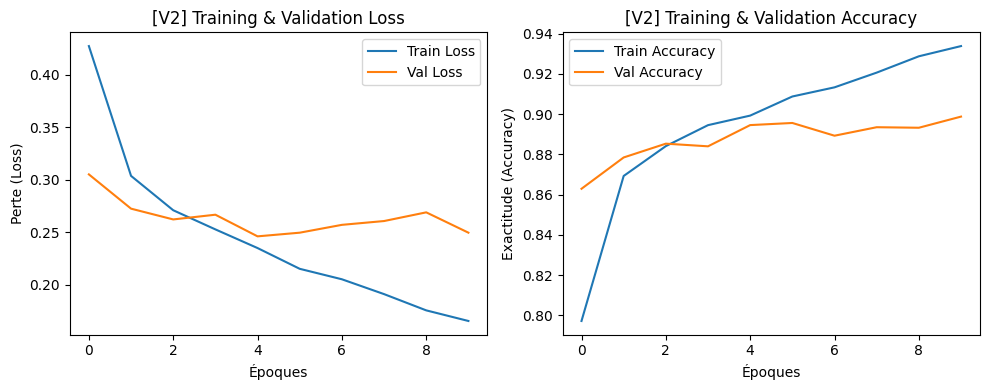

In [ ]:
#modèle V2

def build_model_v2(input_shape=(64, 64, 3)):
    model = Sequential([
        Input(shape=input_shape),

        # Bloc 1
        Conv2D(16, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        # Bloc 2
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        # Aplatissement
        Flatten(),

        # Couche Dense agrandie
        Dense(64, activation='relu'),
        Dropout(0.2),  # Pour contrer le surapprentissage

        # Sortie pour classification binaire (Homme/Femme)
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model




model_v2 = build_model_v2((64, 64, 3))
model_v2.summary()


history_v2 = model_v2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,        # Nombre d'époques
    batch_size=32,    # Taille du batch
    verbose=1
)


test_loss_v2, test_acc_v2 = model_v2.evaluate(X_test, y_test, verbose=0)
print(f"[V2] Test Loss : {test_loss_v2:.4f}")
print(f"[V2] Test Accuracy : {test_acc_v2:.4f}")

# Prédictions sur X_test
y_pred_prob_v2 = model_v2.predict(X_test)
y_pred_v2 = (y_pred_prob_v2 > 0.5).astype("int32")

# Rapport de classification
print(classification_report(y_test, y_pred_v2, target_names=["Homme", "Femme"]))


plt.figure(figsize=(10,4))

# Courbe de loss
plt.subplot(1,2,1)
plt.plot(history_v2.history['loss'], label='Train Loss')
plt.plot(history_v2.history['val_loss'], label='Val Loss')
plt.xlabel('Époques')
plt.ylabel('Perte (Loss)')
plt.legend()
plt.title('[V2] Training & Validation Loss')

# Courbe de l'accuracy
plt.subplot(1,2,2)
plt.plot(history_v2.history['accuracy'], label='Train Accuracy')
plt.plot(history_v2.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Époques')
plt.ylabel('Exactitude (Accuracy)')
plt.legend()
plt.title('[V2] Training & Validation Accuracy')

plt.tight_layout()
plt.show()


Dans la V2 on a:

- Bloc 2 : permet au réseau de détecter des motifs plus complexes.
- Passage de 16→32 filtres : on double la capacité d’extraction de caractéristiques.
- Dense(64) : on augmente la puissance de calcul en sortie.
- Dropout(0.2) : au moins 20 % des neurones sont désactivés de façon aléatoire à chaque batch, ce qui force le réseau à mieux généraliser.

Analyse des courbes :

Toujours un gap entre le train et la validation :
La courbe d’accuracy d’entraînement finit vers ~94 % alors que la validation se stabilise autour de 90 %.
Le modèle commence donc à mémoriser une partie du set d’entraînement.
On peut pousser la régularisation davantage (BatchNormalization, Dropout plus élevé) dans la V3.

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 62, 62, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 62, 62, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 31, 31, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 29, 29, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 29, 29, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 12, 12, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 319,201 (1.22 MB)

 Trainable params: 318,977 (1.22 MB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 87s 175ms/step - accuracy: 0.7657 - loss: 0.5554 - val_accuracy: 0.8732 - val_loss: 0.2880
Epoch 2/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 147s 187ms/step - accuracy: 0.8709 - loss: 0.2921 - val_accuracy: 0.8716 - val_loss: 0.2685
Epoch 3/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 148s 199ms/step - accuracy: 0.8882 - loss: 0.2532 - val_accuracy: 0.8930 - val_loss: 0.2554
Epoch 4/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 81s 171ms/step - accuracy: 0.9092 - loss: 0.2187 - val_accuracy: 0.8840 - val_loss: 0.2594
Epoch 5/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 88s 184ms/step - accuracy: 0.9139 - loss: 0.1963 - val_accuracy: 0.8732 - val_loss: 0.2757
Epoch 6/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 147s 193ms/step - accuracy: 0.9276 - loss: 0.1745 - val_accuracy: 0.8790 - val_loss: 0.2860
Epoch 7/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 132s 172ms/step - accuracy: 0.9363 - loss: 0.1558 - val_accuracy: 0.8888 - val_loss: 0.2590
Epoch 8/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 83s 175ms/step - accuracy: 0.9390 - los

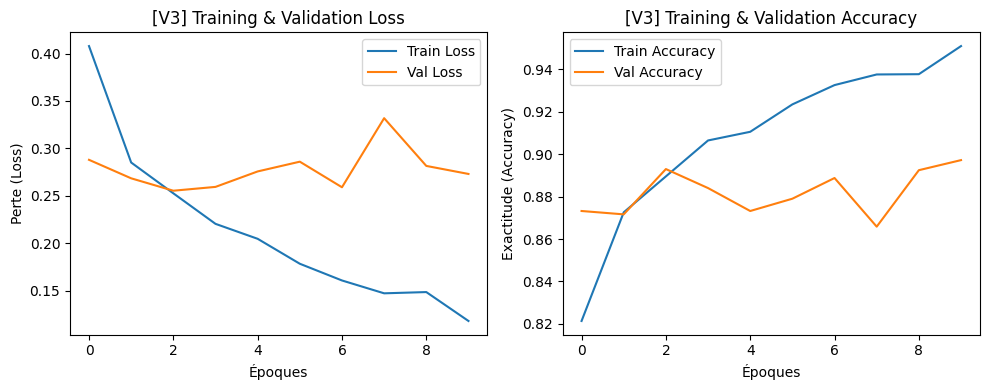

[V3] Test Loss : 0.2947
[V3] Test Accuracy : 0.8965
149/149 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step
              precision    recall  f1-score   support

       Homme       0.90      0.91      0.90      2478
       Femme       0.90      0.88      0.89      2264

    accuracy                           0.90      4742
   macro avg       0.90      0.90      0.90      4742
weighted avg       0.90      0.90      0.90      4742



In [ ]:
 # 1. modèle (V3)

def build_model_v3(input_shape=(64, 64, 3)):
    model = Sequential([
        Input(shape=input_shape),

        # Bloc 1
        Conv2D(16, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Bloc 2
        Conv2D(32, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Bloc 3
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Flatten(),

        # Couche Dense agrandie
        Dense(128, activation='relu'),
        Dropout(0.3),  # plus le dropout est grand, plus y'a de la régularisation

        # Sortie binaire (sigmoid pour Homme/Femme)
        Dense(1, activation='sigmoid')
    ])

    # Compilation
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

model_v3 = build_model_v3((64, 64, 3))
model_v3.summary()


history_v3 = model_v3.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,         # Ajuster selon vos besoins
    batch_size=32,
    verbose=1
)


plt.figure(figsize=(10,4))

# Courbe du loss
plt.subplot(1,2,1)
plt.plot(history_v3.history['loss'], label='Train Loss')
plt.plot(history_v3.history['val_loss'], label='Val Loss')
plt.xlabel('Époques')
plt.ylabel('Perte (Loss)')
plt.legend()
plt.title('[V3] Training & Validation Loss')

# Courbe de l'accuracy
plt.subplot(1,2,2)
plt.plot(history_v3.history['accuracy'], label='Train Accuracy')
plt.plot(history_v3.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Époques')
plt.ylabel('Exactitude (Accuracy)')
plt.legend()
plt.title('[V3] Training & Validation Accuracy')

plt.tight_layout()
plt.show()


test_loss_v3, test_acc_v3 = model_v3.evaluate(X_test, y_test, verbose=0)
print(f"[V3] Test Loss : {test_loss_v3:.4f}")
print(f"[V3] Test Accuracy : {test_acc_v3:.4f}")

# Prédictions et rapport de classification
y_pred_prob_v3 = model_v3.predict(X_test)
y_pred_v3 = (y_pred_prob_v3 > 0.5).astype("int32")

print(classification_report(y_test, y_pred_v3, target_names=["Homme", "Femme"]))


Grâce à trois blocs de convolutions au lieu de deux, et des filtres plus nombreux (16/32/64), le réseau devrait mieux extraire les caractéristiques (joue, menton, cheveux, etc.).

La BatchNormalization réduit la variance interne des activations, facilitant l’entraînement et limitant le surapprentissage.

Le Dropout(0.3) renforce encore la régularisation.

Interprétation des résultats :

Accuracy : Environ 90 % sur le test, ce qui constitue un léger gain par rapport à V2 ( ~88–89 %).

Les courbes montrent encore un écart entre le train et la validation : la loss d’entraînement descend beaucoup (jusqu’à ~0.10) pendant que la validation fluctue autour de ~0.25–0.30. Idem pour l’accuracy, proche de ~95 % sur le train et ~90 % en validation.
Cela indique toujours un surapprentissage. Nous avons déjà introduit de la BatchNormalization et un Dropout (0.3).

Donc pour la V4, on va combiner un 4ᵉ bloc convolutionnel ET de la Data Augmentation :    
Augmenter la profondeur ou le nombre de filtres peut encore améliorer la capacité d’extraction de caractéristiques, mais ça risque d’aggraver l’overfitting si l’on ne compense pas davantage.

On augmentera auss le Dropout, ajoutera un bloc ou un second Dropout dans la partie Dense, etc.
Data Augmentation : générer des variations (flips, rotations, zooms, etc.) pour enrichir le dataset et forcer le réseau à mieux généraliser.

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom (RandomZoom)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64, 64, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │              

 Total params: 361,313 (1.38 MB)

 Trainable params: 360,577 (1.38 MB)

 Non-trainable params: 736 (2.88 KB)

Epoch 1/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 138s 269ms/step - accuracy: 0.7109 - loss: 0.6298 - val_accuracy: 0.8231 - val_loss: 0.4070
Epoch 2/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 140s 266ms/step - accuracy: 0.8148 - loss: 0.4050 - val_accuracy: 0.8553 - val_loss: 0.3352
Epoch 3/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 140s 261ms/step - accuracy: 0.8303 - loss: 0.3765 - val_accuracy: 0.7944 - val_loss: 0.4353
Epoch 4/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 141s 259ms/step - accuracy: 0.8456 - loss: 0.3541 - val_accuracy: 0.8590 - val_loss: 0.3206
Epoch 5/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 143s 260ms/step - accuracy: 0.8606 - loss: 0.3237 - val_accuracy: 0.8640 - val_loss: 0.3055
Epoch 6/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 142s 260ms/step - accuracy: 0.8671 - loss: 0.3103 - val_accuracy: 0.8777 - val_loss: 0.2776
Epoch 7/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 120s 253ms/step - accuracy: 0.8701 - loss: 0.2938 - val_accuracy: 0.8859 - val_loss: 0.2625
Epoch 8/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 123s 260ms/step - accuracy: 0.8713 -

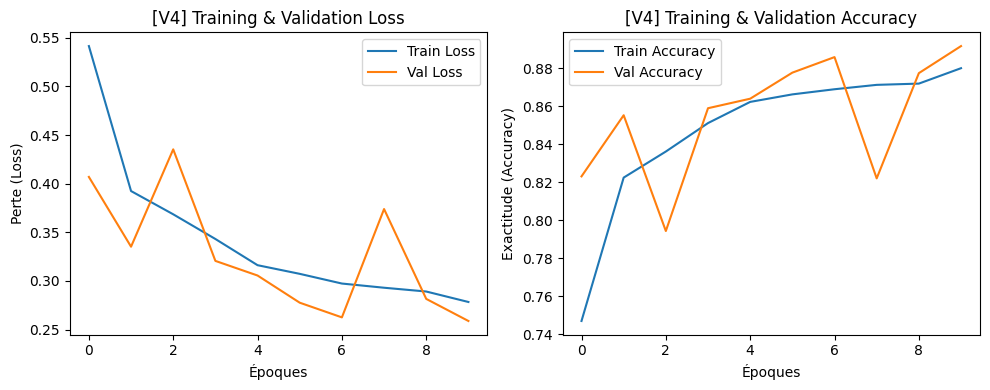

[V4] Test Loss : 0.2676
[V4] Test Accuracy : 0.8838
149/149 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step
              precision    recall  f1-score   support

       Homme       0.88      0.90      0.89      2478
       Femme       0.89      0.86      0.88      2264

    accuracy                           0.88      4742
   macro avg       0.88      0.88      0.88      4742
weighted avg       0.88      0.88      0.88      4742



In [ ]:
def build_model_v4(input_shape=(64, 64, 3)):
    model = Sequential([
        # Couches de Data Augmentation
        # (appliquées directement en entrée)
        Input(shape=input_shape),
        RandomFlip("horizontal"),         # Symétrie horizontale aléatoire
        RandomRotation(0.1),             # Rotation aléatoire jusqu'à 10%
        RandomZoom(0.1),                 # Zoom aléatoire jusqu'à 10%

        # Bloc 1
        Conv2D(16, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Bloc 2
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Bloc 3
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Bloc 4
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Flatten(),

        # Couche Dense agrandie
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),  # Dropout plus élevé

        # Sortie binaire (Homme/Femme)
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

model_v4 = build_model_v4((64, 64, 3))
model_v4.summary()

history_v4 = model_v4.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    verbose=1
)


plt.figure(figsize=(10,4))

# Courbe de la fonction de perte
plt.subplot(1,2,1)
plt.plot(history_v4.history['loss'], label='Train Loss')
plt.plot(history_v4.history['val_loss'], label='Val Loss')
plt.xlabel('Époques')
plt.ylabel('Perte (Loss)')
plt.legend()
plt.title('[V4] Training & Validation Loss')

# Courbe de accuracy
plt.subplot(1,2,2)
plt.plot(history_v4.history['accuracy'], label='Train Accuracy')
plt.plot(history_v4.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Époques')
plt.ylabel('Exactitude (Accuracy)')
plt.legend()
plt.title('[V4] Training & Validation Accuracy')

plt.tight_layout()
plt.show()

test_loss_v4, test_acc_v4 = model_v4.evaluate(X_test, y_test, verbose=0)
print(f"[V4] Test Loss : {test_loss_v4:.4f}")
print(f"[V4] Test Accuracy : {test_acc_v4:.4f}")

# Prédictions et rapport de classification
y_pred_prob_v4 = model_v4.predict(X_test)
y_pred_v4 = (y_pred_prob_v4 > 0.5).astype("int32")

print(classification_report(y_test, y_pred_v4, target_names=["Homme", "Femme"]))


V4 :
4 blocs de convolutions : (16, 32, 64, 128)
BatchNormalization après chaque bloc pour stabiliser l’apprentissage.
Dropout augmenté à 0.4 dans la couche Dense finale.
Flatten → Dense(128) (avec BatchNormalization aussi dans la partie Dense).


Interprétation des résultats : flemme

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip_1 (RandomFlip)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_1 (RandomRotation)   │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_1 (RandomZoom)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 64, 64, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 64, 64, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 32, 32, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │              

 Total params: 361,313 (1.38 MB)

 Trainable params: 360,577 (1.38 MB)

 Non-trainable params: 736 (2.88 KB)

Epoch 1/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 135s 267ms/step - accuracy: 0.6996 - loss: 0.6502 - val_accuracy: 0.8134 - val_loss: 0.3953
Epoch 2/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 140s 263ms/step - accuracy: 0.8188 - loss: 0.4082 - val_accuracy: 0.8382 - val_loss: 0.3537
Epoch 3/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 141s 260ms/step - accuracy: 0.8385 - loss: 0.3632 - val_accuracy: 0.8566 - val_loss: 0.3206
Epoch 4/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 121s 255ms/step - accuracy: 0.8505 - loss: 0.3412 - val_accuracy: 0.8785 - val_loss: 0.2948
Epoch 5/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 144s 259ms/step - accuracy: 0.8547 - loss: 0.3245 - val_accuracy: 0.8764 - val_loss: 0.2915
Epoch 6/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 143s 261ms/step - accuracy: 0.8599 - loss: 0.3252 - val_accuracy: 0.8542 - val_loss: 0.3161
Epoch 7/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 142s 262ms/step - accuracy: 0.8652 - loss: 0.3095 - val_accuracy: 0.8479 - val_loss: 0.3334
Epoch 8/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 141s 261ms/step - accuracy: 0.8307 -

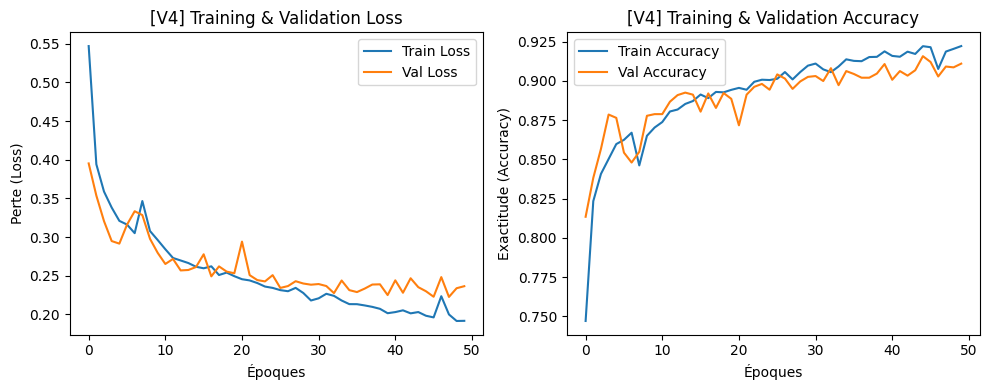

[V4] Test Loss : 0.2316
[V4] Test Accuracy : 0.9062
149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step
              precision    recall  f1-score   support

       Homme       0.93      0.89      0.91      2478
       Femme       0.88      0.93      0.90      2264

    accuracy                           0.91      4742
   macro avg       0.91      0.91      0.91      4742
weighted avg       0.91      0.91      0.91      4742



In [ ]:
def build_model_v4(input_shape=(64, 64, 3)):
    model = Sequential([
        # Couches de Data Augmentation
        # (appliquées directement en entrée)
        Input(shape=input_shape),
        RandomFlip("horizontal"),         # Symétrie horizontale aléatoire
        RandomRotation(0.1),             # Rotation aléatoire jusqu'à 10%
        RandomZoom(0.1),                 # Zoom aléatoire jusqu'à 10%

        # Bloc 1
        Conv2D(16, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Bloc 2
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Bloc 3
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Bloc 4
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Flatten(),

        # Couche Dense agrandie
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),  # Dropout plus élevé

        # Sortie binaire (Homme/Femme)
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

model_v4 = build_model_v4((64, 64, 3))
model_v4.summary()

history_v4 = model_v4.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)


plt.figure(figsize=(10,4))

# Courbe de la fonction de perte
plt.subplot(1,2,1)
plt.plot(history_v4.history['loss'], label='Train Loss')
plt.plot(history_v4.history['val_loss'], label='Val Loss')
plt.xlabel('Époques')
plt.ylabel('Perte (Loss)')
plt.legend()
plt.title('[V4] Training & Validation Loss')

# Courbe de l'accuracy
plt.subplot(1,2,2)
plt.plot(history_v4.history['accuracy'], label='Train Accuracy')
plt.plot(history_v4.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Époques')
plt.ylabel('Exactitude (Accuracy)')
plt.legend()
plt.title('[V4] Training & Validation Accuracy')

plt.tight_layout()
plt.show()

test_loss_v4, test_acc_v4 = model_v4.evaluate(X_test, y_test, verbose=0)
print(f"[V4] Test Loss : {test_loss_v4:.4f}")
print(f"[V4] Test Accuracy : {test_acc_v4:.4f}")

# Prédictions et rapport de classification
y_pred_prob_v4 = model_v4.predict(X_test)
y_pred_v4 = (y_pred_prob_v4 > 0.5).astype("int32")

print(classification_report(y_test, y_pred_v4, target_names=["Homme", "Femme"]))


Après 50 époques, on atteint ~90.6 % de test accuracy, ce qui est supérieur à certaines itérations précédentes (V2, V3).
L’entraînement a continué à diminuer la perte (Train Loss ~0.20) alors que la Validation Loss se situe autour de 0.23.
Les courbes de loss/accuracy montrent qu’au bout de ~30 à 40 époques, les gains deviennent plus modestes. Peut être inutile d’aller jusqu’à 50 époques si le modèle n’améliore plus les performances en validation ou commence à sur-apprendre. D'où le early stopping qu'on mettra dans la v5 (et éventuellement en ModelCheckpoint)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip_1 (RandomFlip)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_1 (RandomRotation)   │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_1 (RandomZoom)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 64, 64, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │              

 Total params: 361,313 (1.38 MB)

 Trainable params: 360,577 (1.38 MB)

 Non-trainable params: 736 (2.88 KB)

Epoch 1/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 154s 301ms/step - accuracy: 0.7033 - loss: 0.6408 - val_accuracy: 0.8005 - val_loss: 0.4171
Epoch 2/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 195s 289ms/step - accuracy: 0.8103 - loss: 0.4260 - val_accuracy: 0.8208 - val_loss: 0.3893
Epoch 3/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 137s 289ms/step - accuracy: 0.8311 - loss: 0.3680 - val_accuracy: 0.7351 - val_loss: 0.5471
Epoch 4/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 145s 296ms/step - accuracy: 0.8356 - loss: 0.3704 - val_accuracy: 0.8627 - val_loss: 0.3211
Epoch 5/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 140s 291ms/step - accuracy: 0.8520 - loss: 0.3327 - val_accuracy: 0.8614 - val_loss: 0.3159
Epoch 6/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 145s 297ms/step - accuracy: 0.8681 - loss: 0.3051 - val_accuracy: 0.8566 - val_loss: 0.3224
Epoch 7/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 141s 296ms/step - accuracy: 0.8603 - loss: 0.3036 - val_accuracy: 0.8513 - val_loss: 0.3370
Epoch 8/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 137s 288ms/step - accuracy: 0.8687 -

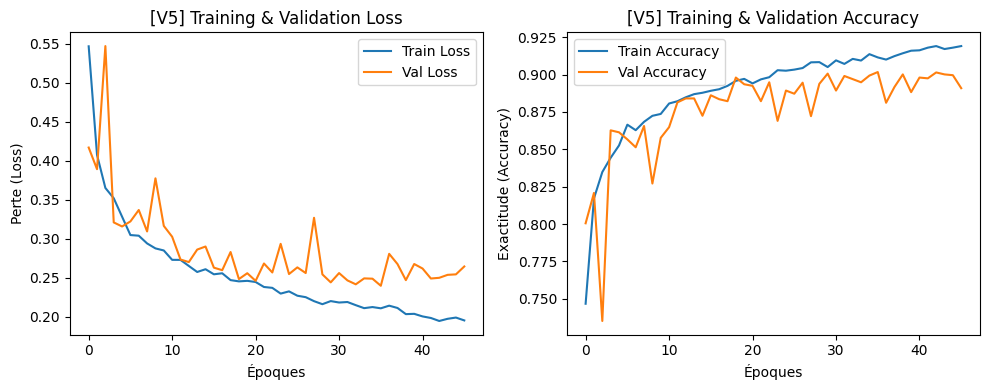

[V5] Test Loss : 0.2139
[V5] Test Accuracy : 0.9127
149/149 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/step
              precision    recall  f1-score   support

       Homme       0.92      0.91      0.92      2478
       Femme       0.90      0.92      0.91      2264

    accuracy                           0.91      4742
   macro avg       0.91      0.91      0.91      4742
weighted avg       0.91      0.91      0.91      4742



In [ ]:
#v5
def build_model_v5(input_shape=(64, 64, 3)):
    model = Sequential([
        # Data Augmentation
        Input(shape=input_shape),
        RandomFlip("horizontal"),
        RandomRotation(0.1),
        RandomZoom(0.1),

        # Bloc 1
        Conv2D(16, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Bloc 2
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Bloc 3
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Bloc 4
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Flatten(),

        # Couche Dense + Dropout
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),

        # Sortie binaire
        Dense(1, activation='sigmoid')
    ])

    # Compilation
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


model_v5 = build_model_v5((64, 64, 3))
model_v5.summary()


# Mise en place d'un EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',       # Surveille la val_loss
    patience=10,               # Arrête si pas d'amélioration après 5 époques consécutives
    restore_best_weights=True # Récupère les poids de la meilleure époque
)


history_v5 = model_v5.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,         # Nombre max d'époques
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping]
)

plt.figure(figsize=(10,4))

# Courbe de la fonction de perte
plt.subplot(1,2,1)
plt.plot(history_v5.history['loss'], label='Train Loss')
plt.plot(history_v5.history['val_loss'], label='Val Loss')
plt.xlabel('Époques')
plt.ylabel('Perte (Loss)')
plt.legend()
plt.title('[V5] Training & Validation Loss')

# Courbe de l'accuracy
plt.subplot(1,2,2)
plt.plot(history_v5.history['accuracy'], label='Train Accuracy')
plt.plot(history_v5.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Époques')
plt.ylabel('Exactitude (Accuracy)')
plt.legend()
plt.title('[V5] Training & Validation Accuracy')

plt.tight_layout()
plt.show()


test_loss_v5, test_acc_v5 = model_v5.evaluate(X_test, y_test, verbose=0)
print(f"[V5] Test Loss : {test_loss_v5:.4f}")
print(f"[V5] Test Accuracy : {test_acc_v5:.4f}")

# Prédictions et rapport de classification
y_pred_prob_v5 = model_v5.predict(X_test)
y_pred_v5 = (y_pred_prob_v5 > 0.5).astype("int32")

print(classification_report(y_test, y_pred_v5, target_names=["Homme", "Femme"]))


Train Accuracy : Grimpe lentement jusqu’à ~92–93 %. Cela confirme que le modèle apprend toujours à mieux classer les images d’entraînement (plus d’époques = plus de mémorisation).
Validation Accuracy : Oscille et se stabilise autour de ~88–90 %.
La différence entre la courbe bleue (train) et orange (val) s’accentue un peu au fil des époques, renforçant l’idée d’un overfitting graduel.
Malgré tout, on voit qu’elle reste globalement plus élevée que lors des premières époques (où elle était < 85 %). Donc le réseau a bien progressé, mais plafonne autour des 90 %.

Ici,on permet au réseau de continuer davantage, ce qui fait baisser la train loss, monter la train accuracy, mais n’améliore pas énormément la validation (ça reste ~90 %).
On voit par contre un écart plus net entre le train et la validation.

En augmentant la patience, on laisse sa chance au réseau de chercher à mieux ajuster le jeu d’entraînement, mais si la validation ne s’améliore pas, ça veut dire qu’on est probablement déjà au maximum de ce que l'architecture et ses hyperparamètres peuvent offrir.
Prochaine étape : Mettre un scheduler de learning rate (ou un LR plus faible en fin d’entraînement) peut parfois aider à grappiller quelques points de validation accuracy.

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip_3 (RandomFlip)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_3 (RandomRotation)   │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_3 (RandomZoom)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 64, 64, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 64, 64, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 32, 32, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │              

 Total params: 361,313 (1.38 MB)

 Trainable params: 360,577 (1.38 MB)

 Non-trainable params: 736 (2.88 KB)

Epoch 1/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 146s 292ms/step - accuracy: 0.7166 - loss: 0.6348 - val_accuracy: 0.8144 - val_loss: 0.4313 - learning_rate: 0.0010
Epoch 2/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 141s 290ms/step - accuracy: 0.8046 - loss: 0.4373 - val_accuracy: 0.8405 - val_loss: 0.3727 - learning_rate: 0.0010
Epoch 3/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 148s 303ms/step - accuracy: 0.8411 - loss: 0.3602 - val_accuracy: 0.8382 - val_loss: 0.4117 - learning_rate: 0.0010
Epoch 4/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 200s 299ms/step - accuracy: 0.8428 - loss: 0.3629 - val_accuracy: 0.8429 - val_loss: 0.3441 - learning_rate: 0.0010
Epoch 5/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 196s 287ms/step - accuracy: 0.8583 - loss: 0.3319 - val_accuracy: 0.8558 - val_loss: 0.3205 - learning_rate: 0.0010
Epoch 6/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 147s 297ms/step - accuracy: 0.8669 - loss: 0.3075 - val_accuracy: 0.8603 - val_loss: 0.3168 - learning_rate: 0.0010
Epoch 7/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 137s 288ms/step - accura

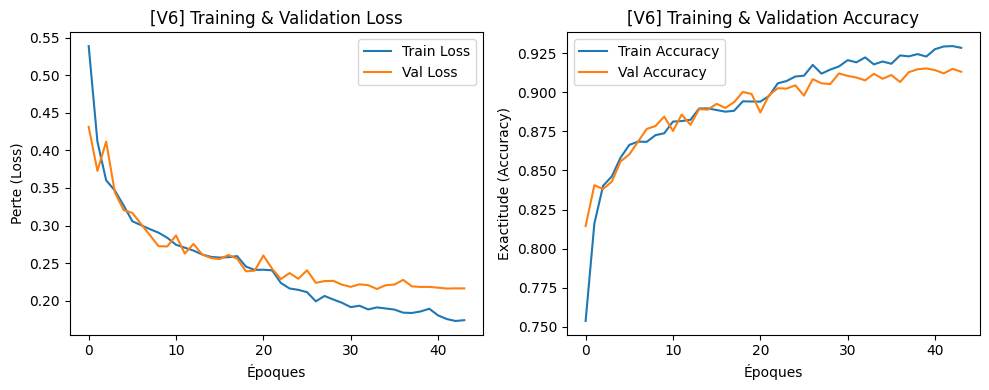

[V6] Test Loss : 0.1948
[V6] Test Accuracy : 0.9232
149/149 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step
              precision    recall  f1-score   support

       Homme       0.93      0.92      0.93      2478
       Femme       0.91      0.93      0.92      2264

    accuracy                           0.92      4742
   macro avg       0.92      0.92      0.92      4742
weighted avg       0.92      0.92      0.92      4742



In [ ]:
def build_model_v6(input_shape=(64, 64, 3)):
    model = Sequential([
        # Data Augmentation
        Input(shape=input_shape),
        RandomFlip("horizontal"),
        RandomRotation(0.1),
        RandomZoom(0.1),

        # Bloc 1
        Conv2D(16, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Bloc 2
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Bloc 3
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Bloc 4
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Flatten(),

        # Couche Dense + Dropout
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),

        # Sortie binaire (Homme/Femme)
        Dense(1, activation='sigmoid')
    ])

    # Compilation
    model.compile(
        optimizer=Adam(learning_rate=0.001),  # LR initial
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


model_v6 = build_model_v6((64, 64, 3))
model_v6.summary()

# 3. Callbacks: EarlyStopping + ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Surveille la val_loss
    factor=0.5,          # Divise le LR par 2
    patience=3,          # Après 3 époques sans amélioration
    min_lr=1e-5          # LR plancher
)


history_v6 = model_v6.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,          # Nombre max d'époques
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)


plt.figure(figsize=(10,4))

# Courbe de la fonction de perte
plt.subplot(1,2,1)
plt.plot(history_v6.history['loss'], label='Train Loss')
plt.plot(history_v6.history['val_loss'], label='Val Loss')
plt.xlabel('Époques')
plt.ylabel('Perte (Loss)')
plt.legend()
plt.title('[V6] Training & Validation Loss')

# Courbe d’accuracy
plt.subplot(1,2,2)
plt.plot(history_v6.history['accuracy'], label='Train Accuracy')
plt.plot(history_v6.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Époques')
plt.ylabel('Exactitude (Accuracy)')
plt.legend()
plt.title('[V6] Training & Validation Accuracy')

plt.tight_layout()
plt.show()


test_loss_v6, test_acc_v6 = model_v6.evaluate(X_test, y_test, verbose=0)
print(f"[V6] Test Loss : {test_loss_v6:.4f}")
print(f"[V6] Test Accuracy : {test_acc_v6:.4f}")

# Prédictions & rapport de classification
y_pred_prob_v6 = model_v6.predict(X_test)
y_pred_v6 = (y_pred_prob_v6 > 0.5).astype("int32")

print(classification_report(y_test, y_pred_v6, target_names=["Homme", "Femme"]))


C'est la meilleure performance jusqu’ici, surpassant légèrement les ~90–91 % des versions précédentes.
La combinaison Data Augmentation + Dropout + BatchNormalization + Scheduler de Learning Rate semble porter ses fruits

Courbes Loss & Accuracy:

La train loss descend régulièrement jusqu’à ~0.15–0.20, signe que le réseau s’adapte très bien aux données d’entraînement.

La validation loss est un peu plus haute, autour de ~0.20–0.25, mais reste globalement assez proche de la train loss : l’écart entre train et validation n’est pas excessif.

La validation accuracy suit la courbe d’entraînement de près : ça indique une bonne généralisation et peu d’overfitting.

Callbacks :


EarlyStopping (patience=10) a  laissé l’entraînement se prolonger ; s’il n’y a pas d’amélioration notable de la val_loss après 10 époques consécutives, l’entraînement s’interrompt.

ReduceLROnPlateau (patience=3, factor=0.5, min_lr=1e-5) : Le principe général de ReduceLROnPlateau est d’adapter dynamiquement le taux d’apprentissage (learning rate) lorsqu’il constate une stagnation dans la métrique qu'on surville (généralement la perte de validation, val_loss).  Dans notre modèle, on regarde la val_loss après chaque époque pour déterminer s'il s’améliore ou non.

Une fois la patience atteinte sans amélioration, ReduceLROnPlateau réduit le taux d’apprentissage (LR) en le multipliant par un facteur (le paramètre factor)
Après avoir diminué le LR, le compteur de patience repart à zéro.
Si l’entraînement recommence à s’améliorer, tant mieux ; sinon, au bout de 3 nouvelles époques (pour patience=3) sans amélioration, il rediminue encore le LR.

Pour éviter de descendre le LR à l’infini, on fixe un min_lr, en-dessous duquel le scheduler ne va pas.
Exemple : min_lr=1e-5. Ainsi, même après plusieurs réductions, le LR ne sera jamais inférieur à 0.00001.

Le but est de trouver un compromis :

Au début, un LR plus élevé accélère l’apprentissage.
Puis, quand la courbe se stabilise et que le réseau ne s’améliore plus, on baisse le LR pour affiner l’entraînement et potentiellement dénicher un minimum local plus bas.
Si le réseau ne progresse plus à un LR donné, la réduction de ce LR peut permettre de mieux ajuster les poids et de gagner quelques points de performance.



In [ ]:
#test branch git